# Chap02 - More PyMC

## 2.1 서론

- `PyMC` 구문과 디자인 패턴에 대해 알 수 있다.
- 베이지안 관점에서 시스템을 모델링 하는 방법을 알 수 있다.
- 베이지안 모델의 적합도 평가 및 데이터 시각화 기법을 알 수 있다.

### 2.1.1 부모와 자식 관계

> **부모변수**(Parent variable)는 다른 변수에 영항을 주는 변수다.

> **자식변수**(Child variable)는 다른 변수의 영향을 받는 즉, 부모변수에 종속된다.

어느 변수라도 부모변수가 될 수 있고, 동시에 자식변수가 될 수 있다.

In [1]:
import pymc as pm
import matplotlib

matplotlib.rc('font', family='NanumGothic')  # linux
# matplotlib.rc('font', family='AppleGothic')  # Mac

lambda_ = pm.Exponential('poisson_param', 1)
# 다음 변수 호출에 사용된다.
# lambda_는 data_generator의 부모변수다.
data_generator = pm.Poisson('data_generator', lambda_)
# data_generator는 data_plus_one의 부모변수다
data_plus_one = data_generator + 1

In [2]:
print("Children of 'lambda_': \n", lambda_.children)
print("\nParents of 'data_generator': \n", data_generator.parents)
print("\nChildren of 'data_generator': \n", data_generator.children)

Children of 'lambda_': 
 {<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x7fd47fe8a1d0>}

Parents of 'data_generator': 
 {'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x7fd4dd7ca710>}

Children of 'data_generator': 
 {<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x7fd4dd7ca6a0>}


### 2.1.2 `PyMC` 변수

모든 `PyMC`변수는 `value` 속성을 가진다. 이 속성을 통해 변수의 **현재값**(random한 값)을 생성한다.

자식변수(child variable)의 값은 부모변수 값이 주어질 때 변경된다.

In [3]:
print('lambda_.value =', lambda_.value)
print('data_generator.value =', data_generator.value)
print('data_plus_one.value =', data_plus_one.value)

lambda_.value = 1.5477627548674662
data_generator.value = 1
data_plus_one.value = 2


`PyMC`은 `stochastic`과 `deterministic` 두 가지 변수를 가진다.
- `stochastic` 변수는 값이 정해지지 않은 변수로 Random(난수)이며 `Poisson, DiscreteUniform, Exponential` 클래스의 인스턴스가 있다.
- `deterministic` 변수는 고정된(?) 값이다. 

#### stochastic 변수 초기화

```python
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
```

`0, 4`는 `DiscreteUniform`의 난수 하한선과 상한선이다. `name` arg는 분석 후반에 사후확률분포를 가져올 때 사용하므로 이름을 사용하는 것이 좋다.

In [4]:
# ??를 이용해 확인하기
??pm.DiscreteUniform

Init signature: pm.DiscreteUniform(*args, **kwds)
Docstring:     
D = DiscreteUniform(name, lower, upper, value=None, observed=False, size=1, trace=True, rseed=True, doc=None, verbose=-1, debug=False)

Stochastic variable with DiscreteUniform distribution.
Parents are: lower, upper.

Docstring of log-probability function:

    Discrete uniform log-likelihood.

    .. math::
        f(x \mid lower, upper) = \frac{1}{upper-lower}

    :Parameters:
      - `x` : [int] :math:`lower \leq x \leq upper`
      - `lower` : Lower limit.
      - `upper` : Upper limit (upper > lower).

    
File:           ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:           StochasticMeta


In [5]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
print('stochastic :', some_variable.value)

stochastic : 1


변수를 여러개를 랜덤하게 출력하고 싶을 경우 `size` keyword를 이용하여 독립적인 확률변수의 리스트가 만들어 진다.

In [6]:
betas = pm.Uniform('betas', 0, 1, size=10)
print('betas :', betas.value)
# ??pm.Uniform

betas : [ 0.00844753  0.77499049  0.88087437  0.46655823  0.99769921  0.98288758
  0.92054273  0.86371129  0.51102073  0.95591721]


#### `random()` 호출하기

`stochastic` 변수의 `random()` 메소드를 호출하여 새 난수값을 만들 수 있다.

In [7]:
lambda_1 = pm.Exponential("lambda_1", 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print("Initialized values...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")
print(lambda_1.random(), lambda_2.random(), tau.random())
print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

Initialized values...
lambda_1.value = 0.470
lambda_2.value = 0.906
tau.value = 0.000 

0.6015752324996557 1.0493165870477623 6
After calling random() on the variables...
lambda_1.value = 0.602
lambda_2.value = 1.049
tau.value = 6.000


#### deterministic 변수

deterministic 변수는 아래와 같이 **데코레이터**를 이용해 정의해 줄 수 있다.

```python
@pm.deterministic
def some_deterministic_var(v1=v1, ):
    # type code here
```

In [8]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [11]:
# sample code : 1장 1.4 참고
import numpy as np

n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

위의 식에서 $\tau, \lambda_1, \lambda_2$를 안다면 $\lambda$를 알 수 있는 것은 당연한 사실이다. 따라서 $\lambda$는 deterministic 변수이다.

`deterministic` 데코레이터 내부에서 stochastic 변수는 stochastic 변수가 아니라 스칼라나 `numpy` 배열 처럼 작동한다. 

In [16]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)

@pm.deterministic
def some_deterministic(stoch=some_variable):  # 함수 작성 시 반드시 kwarg를 사용해야 한다. 
    # stoch.value**2 일 경우 AttributeError가 발생한다. 
    return stoch**2

### 2.1.3 모델에 관측 포함하기

예를 들어 $\lambda_1$에 대한 사전확률분포를 살펴보자

(0, 8)

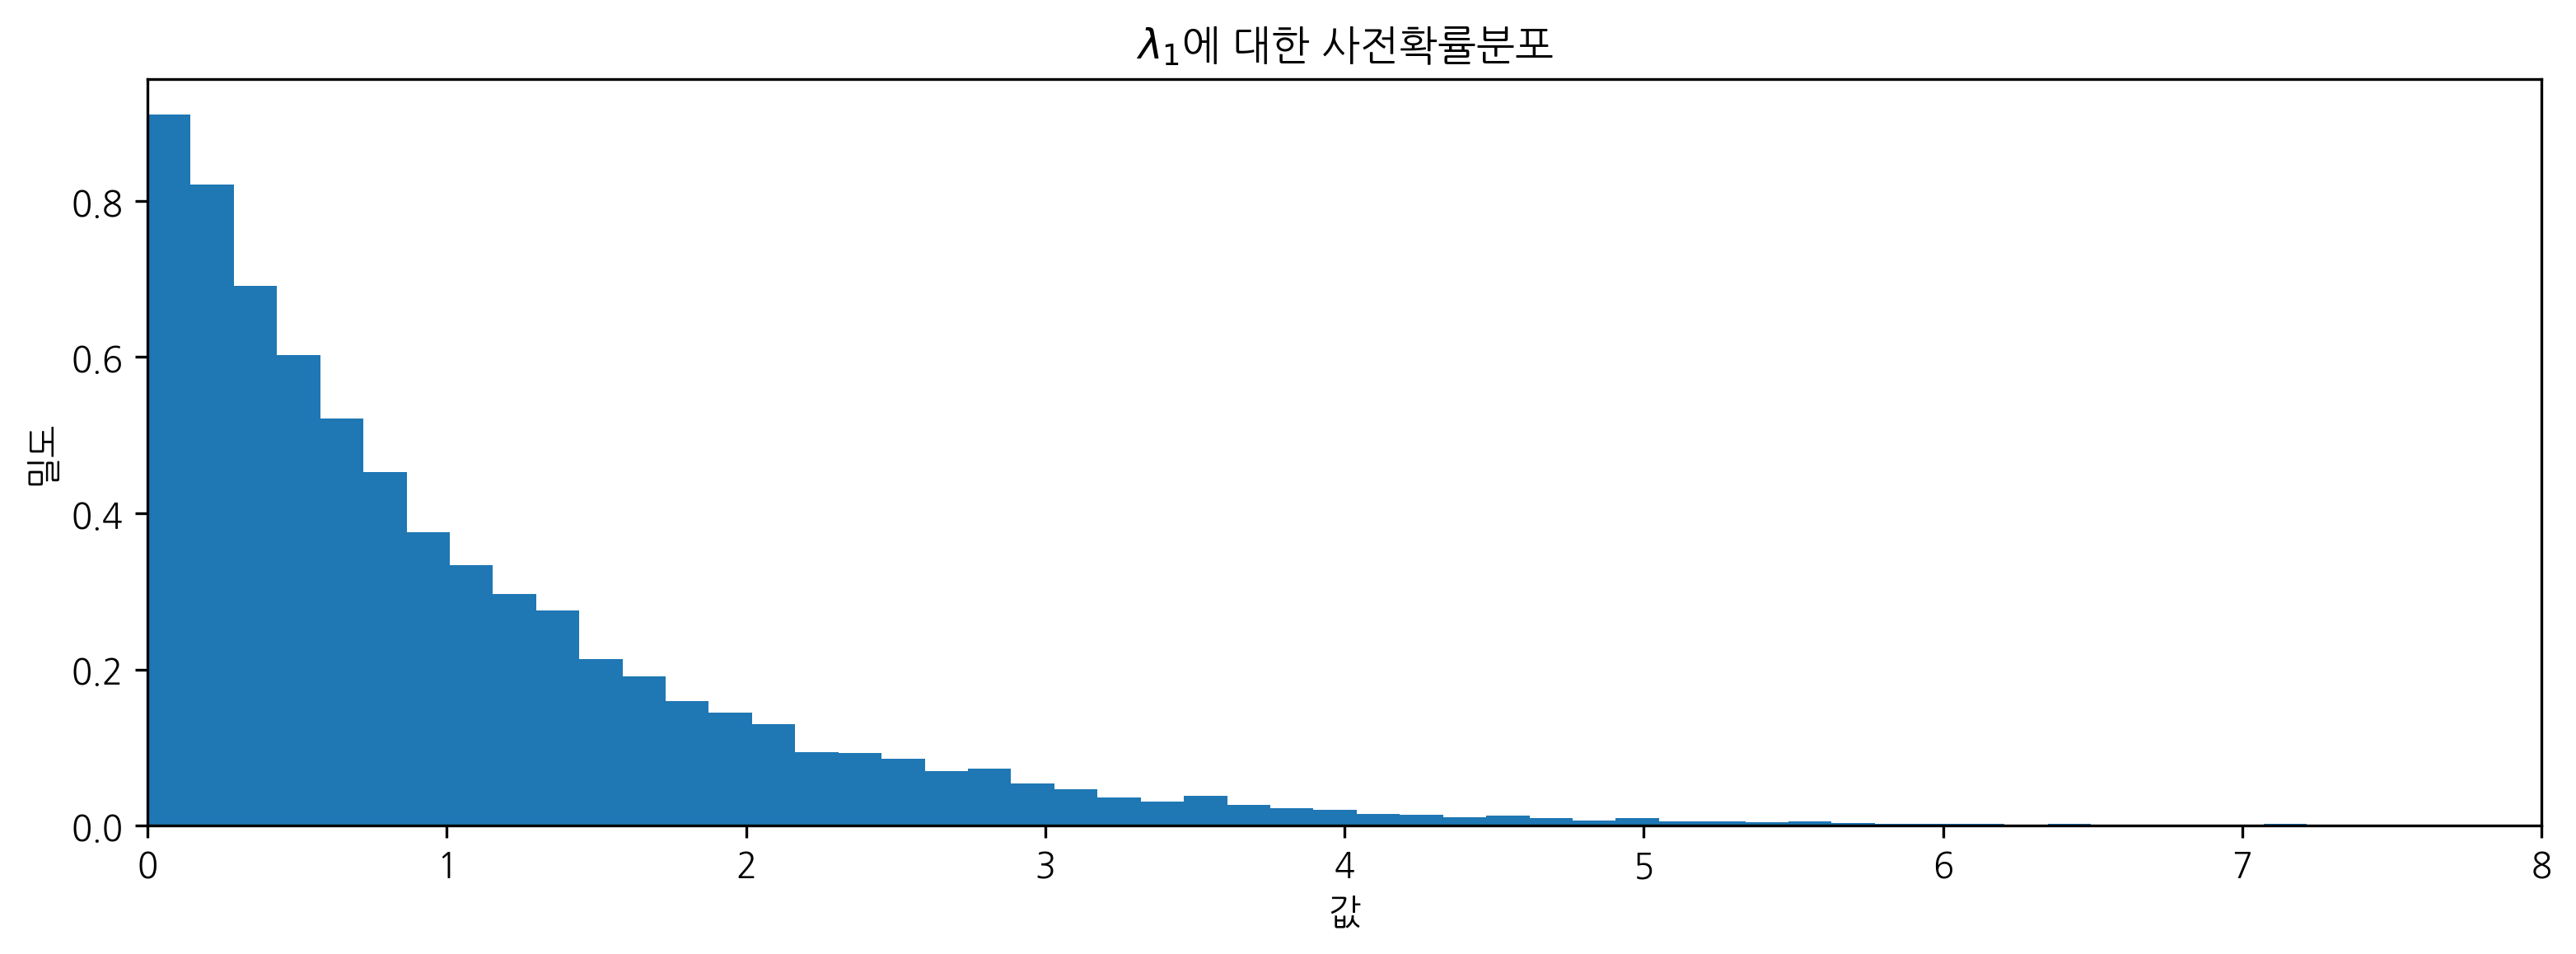

In [23]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

lambda_1 = pm.Exponential("lambda_1", 1)
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title('$\lambda_1$에 대한 사전확률분포')
plt.xlabel('값')
plt.ylabel('밀도')
plt.xlim(0, 8)

사전확률분포를 알아보았으니, 데이터/증거/관측치 $X$를 모델에 포함시켜 보자.

`PyMC` 확률변수는 boolean을 받는 kwarg인 `observed`가 있다. 이 `observed`의 역할은 변수의 현재값을 고정하는 즉, 값을 변경 불가능하게 만든다.

In [25]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)

print('value:', fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value: [10  5]
calling .random()
value:  [10  5]


In [26]:
# sample code

data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


### 2.1.4 마지막으로

1.4에서 문자메시지 예제 데이터를 통해 모델링을 했을 때, `pm.Model` 클래스로 만들었다. 이러한 `Model` 클래스를 사용하여 변수를 하나의 단위로 분석할 수 있다.

In [30]:
# sample code
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])
model